
    
# Imports

In [8]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import cv2 as cv2
import opendatasets as od

from shutil import copyfile
from keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator 

In [9]:
od.download('https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset')

Skipping, found downloaded files in ".\microsoft-catsvsdogs-dataset" (use force=True to force download)



# Data Preprocessing

In [10]:
#Define data path
CAT_DIR = 'microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = 'microsoft-catsvsdogs-dataset/PetImages/Dog'

try:
    os.mkdir('cats-v-dogs')
    os.mkdir('cats-v-dogs/training')
    os.mkdir('cats-v-dogs/validation')
    os.mkdir('cats-v-dogs/training/cats')
    os.mkdir('cats-v-dogs/training/dogs')
    os.mkdir('cats-v-dogs/validation/cats')
    os.mkdir('cats-v-dogs/validation/dogs')
except OSError:
    print('Error failed to make directory')

**Let's check the distribution of the data**

In [11]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

**The data is perfectly balanced**


**Now let's create  a function to split the   data**

In [12]:

def split_data(main_dir, training_dir, validation_dir, split_size):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding

    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:] # validation split

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory


**Now let's call the function to create the  training/validation data**

In [13]:
split_data(CAT_DIR, 'cats-v-dogs/training/cats','cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, 'cats-v-dogs/training/dogs', 'cats-v-dogs/validation/dogs', 0.9)

In [14]:

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('cats-v-dogs/training',
                                                    batch_size = 100,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  valid_datagen.flow_from_directory( 'cats-v-dogs/validation',
                                                          batch_size  = 100,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Now let's visualize the data**

In [15]:

def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

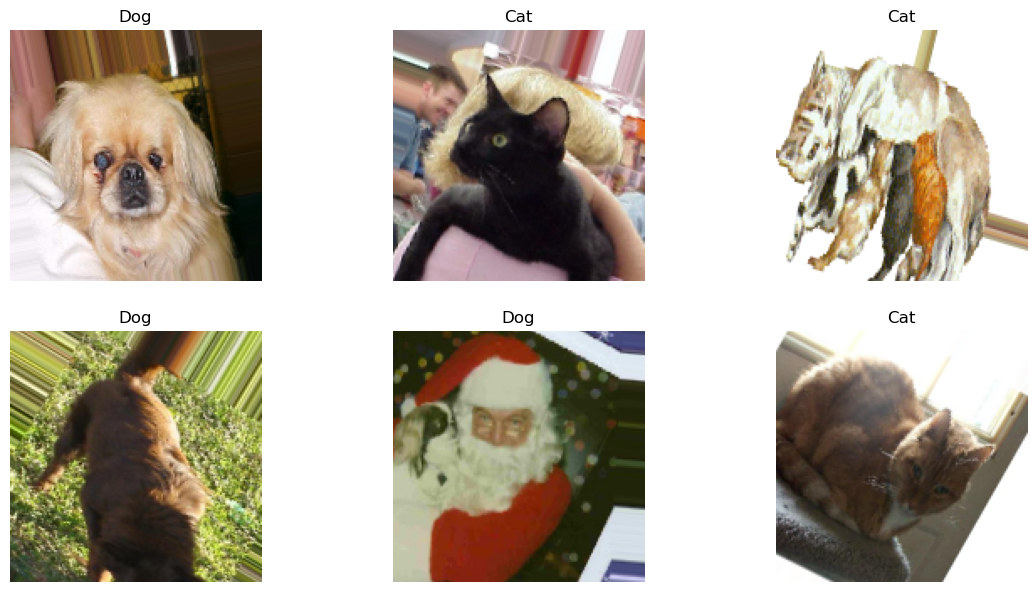

In [16]:
plot_data(train_generator,7)

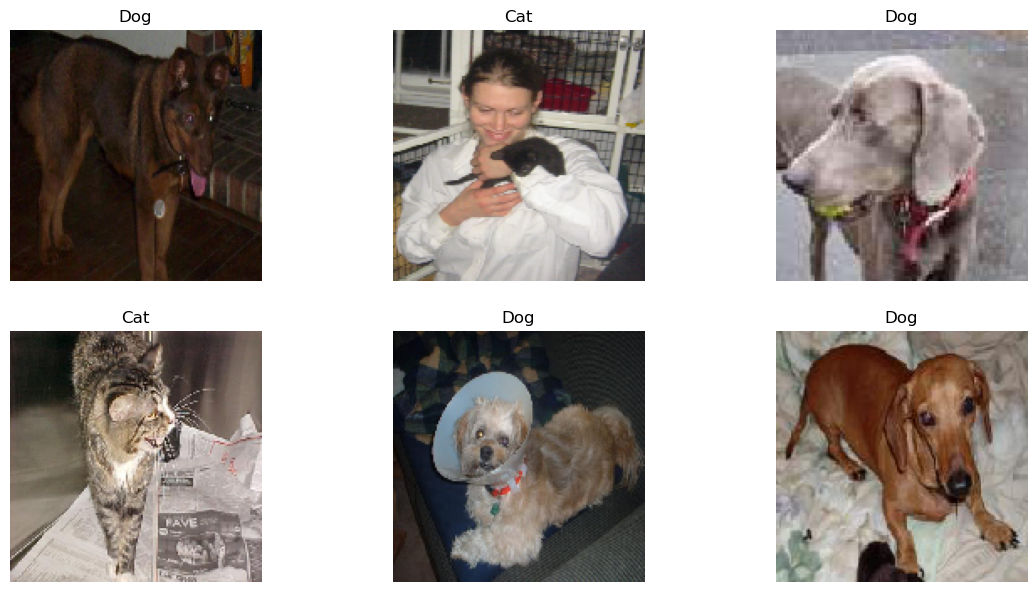

In [17]:
plot_data(validation_generator,7)


    
# Transfer Learning
**We'll be using InceptionV3**

In [18]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))


for layer in inception.layers[:-10]:
    layer.trainable = False # Freeze weights of all layers till except the last 10
    
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output




87910968/87910968 [==============================] - 39s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [19]:

x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inception.input, predictions)

# model.summary()

In [20]:
def scheduler(epoch, lr):
    
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [21]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [23]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,callbacks=[callback])


Epoch 1/5
225/225 [==============================] - 405s 2s/step - loss: 0.1479 - accuracy: 0.9516 - val_loss: 0.0730 - val_accuracy: 0.9772 - lr: 1.0000e-04
Epoch 2/5
225/225 [==============================] - 382s 2s/step - loss: 0.1373 - accuracy: 0.9517 - val_loss: 0.0889 - val_accuracy: 0.9776 - lr: 1.0000e-04
Epoch 3/5
225/225 [==============================] - 363s 2s/step - loss: 0.1417 - accuracy: 0.9517 - val_loss: 0.0925 - val_accuracy: 0.9720 - lr: 1.0000e-04
Epoch 4/5
225/225 [==============================] - 333s 1s/step - loss: 0.1231 - accuracy: 0.9562 - val_loss: 0.0782 - val_accuracy: 0.9736 - lr: 1.0000e-04
Epoch 5/5
225/225 [==============================] - 333s 1s/step - loss: 0.1337 - accuracy: 0.9557 - val_loss: 0.0796 - val_accuracy: 0.9744 - lr: 1.0000e-04



    
# Evaluation

[](http://)

## View predictions

In [24]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

4/4 [==============================] - 4s 180ms/step


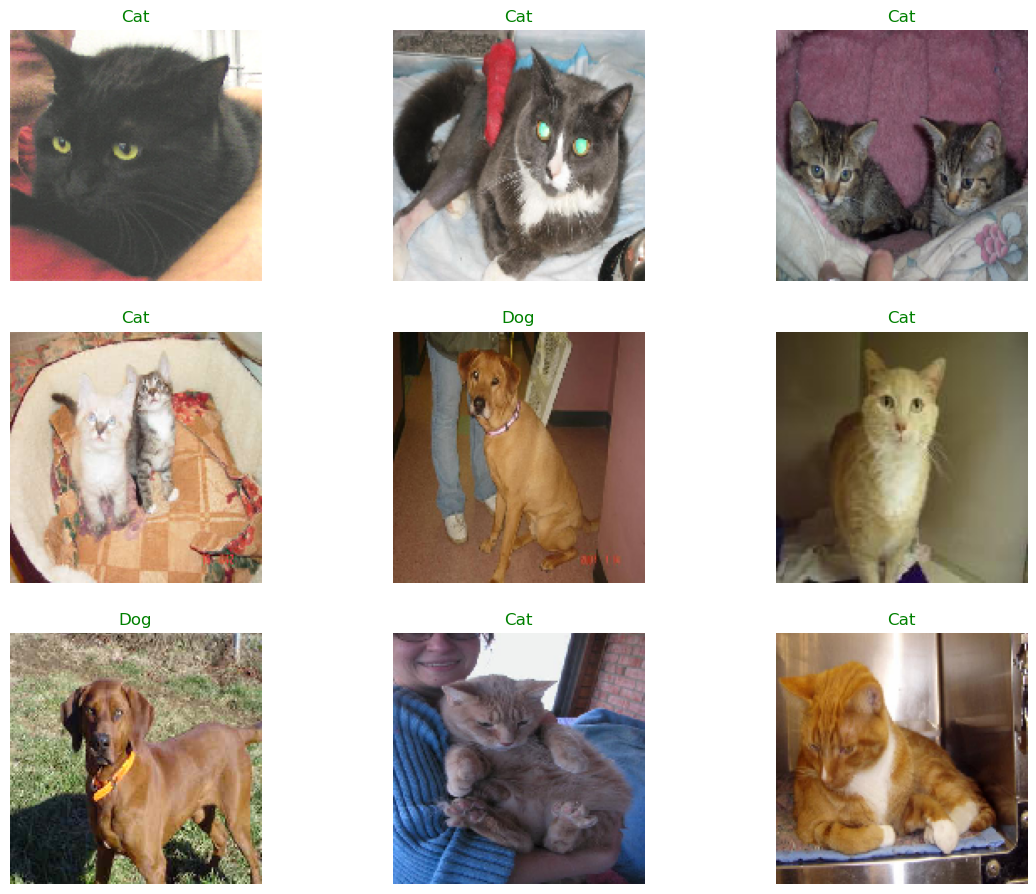

: 

In [25]:
plot_prediction(validation_generator, 10)